# Loading atlas data

This demonstrates the ability of Connectome Utilities to contextualize a network with information from a voxel atlas.
In this example we have a voxel atlas where individual voxels are annotated with identifiers of subregions. 

We use this information to extract connectivity strengths between the individual subregions, i.e. the number of connections between nodes where the source node is placed in one given subregion and the target node in another. Subregions of nodes are determined based on their locations in a coordinate system, which is then looked up in the voxel atlas.


We begin by loading a circuit

In [1]:
import pandas
import numpy
import bluepysnap as snap

circ_fn = "./data/circuit_config_multipop.json"
column_prop_fn = "./data/voxel-based-hex-grid-info-with-conicality.h5"

circ = snap.Circuit(circ_fn)
col_props = pandas.read_hdf(column_prop_fn, "grid-info").set_index("nrrd-file-id")

New we load basic information about nodes into a DataFrame.
To that end, we first write a "loader_config". It specifies the following:
 - Which neurons to load and which of their properties. For this specific example, we include an "atas" entry that loads for each node the associated property in the atlas.
 - Which filter to apply. In this example, we focus on "layer==4" connectivity only
 - How to group the neurons into different classes. Here, we use the property we looked up from the atlas to determine groups.
 

In [2]:
from conntility.circuit_models import neuron_groups

loader_config = {
    "loading": {
        "base_target": "Mosaic", 
        "node_population": "S1nonbarrel_neurons",
        "properties": ["x", "y", "z", "etype", "mtype", "layer", "synapse_class"],
        "atlas": [
            {"data": "./data/column_identities.nrrd",
             "properties": ["column_id"]}
        ]
    },
    "filtering":[
        {
            "column": "layer",
            "value": 4
        }
    ],
    "grouping": [
        {
            "method": "group_by_properties",
            "columns": ["column_id"]
        }
    ]
}


base_grp = neuron_groups.load_group_filter(circ, loader_config)

display(base_grp)
# NOTE: column_id 0 indicates a node is NOT MEMBER OF ANY COLUMN!

,node_ids,etype,layer,mtype,synapse_class,x,y,z,column_id
idx-column_id,,,,,,,,,
59,123440,cADpyr,4,L4_TPC,EXC,3639.910323,-1559.350538,-1869.525788,59
59,134673,cADpyr,4,L4_TPC,EXC,3679.722575,-1580.563802,-1917.387064,59
59,110895,cADpyr,4,L4_UPC,EXC,3766.500775,-1637.219184,-1901.112049,59
59,140404,cADpyr,4,L4_SSC,EXC,3681.246502,-1565.979252,-1925.685275,59
59,115141,cADpyr,4,L4_UPC,EXC,3637.771209,-1646.239775,-2006.704349,59
...,...,...,...,...,...,...,...,...,...
135,122957,cADpyr,4,L4_TPC,EXC,4532.467350,-1034.359545,-2600.513213,135
135,123013,cADpyr,4,L4_TPC,EXC,4525.424803,-943.066338,-2537.523927,135
135,123008,cADpyr,4,L4_TPC,EXC,4581.603906,-1061.946763,-2614.390856,135


"column_id" is the property we loaded from the atlas. It is also used as the index of the DataFrame, which determines the grouping.

#### From here on this example is similar to Example 5.
The biggest difference is, in Example 5 you will see how you can define equivalent groups directly within Connectome Utilities instead of pre-calculating them in an atlas. Also, in Example 5 we use smaller columns. Finally, in Example 5 we see a different approach of first loading connectivity at the neuronal resolution, then reducing the resolution


We use the following to load the matrix of connections _between_ the defined groups.
(Note: There are different functions available for loading connections within groups).

Here, we load the midrange connection count. We could also load local connectivity.

In [3]:
from conntility import circuit_models

M = circuit_models.circuit_matrix_between_groups(circ, base_grp, connectome="midrange__S1nonbarrel_neurons__chemical",
                                                 population="midrange__S1nonbarrel_neurons__chemical", extract_full=True)
M.index = pandas.MultiIndex.from_frame(M.index.to_frame().applymap(int))

Counting...: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


The result is a pandas.Series with connection counts between groups. Indexed by the name of the source / target groups.

In [4]:
valid = M.index.to_frame().applymap(lambda x: x > 0).all(axis=1) # remove entries not associated with a column (0)
M = M.loc[valid]
display(M)

Source node  Target node
118          59             9287.0
99           59             8642.0
118          62             8311.0
99           83             4806.0
118          83             4579.0
99           62             1827.0
106          59             1216.0
             83              637.0
99           72              372.0
106          62              252.0
59           118             168.0
             99              112.0
118          84               74.0
             72               67.0
106          72               43.0
87           83               40.0
62           118              38.0
99           99               31.0
87           59               30.0
99           84               12.0
118          63               11.0
87           72               10.0
62           99                8.0
59           100               8.0
62           100               5.0
87           99                5.0
99           87                4.0
118          103              

We do some re-indexing to turn the output into a ConnectivityMatrix.

First, the current indices of source and target nodes cover a wide range of intege values. We convert them to cover intergers from 0 to N-1 instead. The result is put into a DataFrame with columns "row", and "col".

Next, we look up additional properties associated with the populations of the nodes in the "col_props" DataFrame.

In [5]:
from conntility import ConnectivityMatrix

srt_idx = sorted(numpy.unique(M.index.to_frame().values))
con_idx = M.index.to_frame().applymap(lambda _x: srt_idx.index(_x)).reset_index(drop=True)
con_idx = con_idx.rename(columns={"Source node": "row", "Target node": "col"})
v_props = col_props.loc[srt_idx]

C = ConnectivityMatrix(con_idx, vertex_properties=v_props,
                       edge_properties=M.reset_index(drop=True), # edge weights
                       shape=(len(srt_idx), len(srt_idx)))

We can plot the connectivity matrix

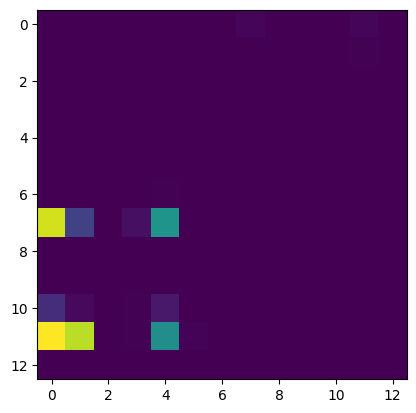

In [6]:
from matplotlib import pyplot as plt

plt.imshow(C.array, interpolation="nearest")

Now we can plot for example the strengths of connections from an exemplary location
NOTE: This is long-range connectivity only, so we do not expect it to peak around the source location

Text(0, 0.5, 'um')

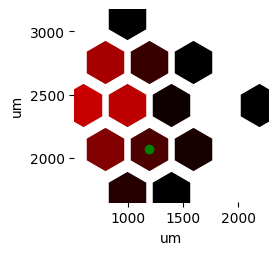

In [7]:
plot_divider = 5
example_idx = 7
exemplary_loc = C.vertices.iloc[example_idx]

ax = plt.figure(figsize=(2.5, 2.5)).gca()

for i, value in enumerate(C.array[example_idx, :]):
    col = [numpy.minimum(numpy.log10(value + 1) / plot_divider, 1), 0, 0]
    loc = C.vertices.iloc[i]
    ax.plot(loc["grid-x"], loc["grid-y"], color=col, ms=30, marker="h")

ax.plot(exemplary_loc["grid-x"], exemplary_loc["grid-y"], marker='o', color="green")
ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")

Neat! Even cooler: Both outgoing and incoming connectivity.
We encode outgoing strength in the "red" channel, incoming in the "blue" channel.

Text(0, 0.5, 'um')

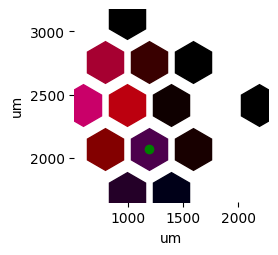

In [8]:
plot_divider = 5
example_idx = 7
exemplary_loc = C.vertices.iloc[example_idx]

ax = plt.figure(figsize=(2.5, 2.5)).gca()

for i in range(len(C)):
    value_row = C.array[example_idx, i]
    value_col = C.array[i, example_idx]
    col = [numpy.minimum(numpy.log10(value_row + 1) / plot_divider, 1), 0, 
           numpy.minimum(numpy.log10(value_col + 1) / plot_divider, 1)]
    loc = C.vertices.iloc[i]
    ax.plot(loc["grid-x"], loc["grid-y"], color=col, ms=30, marker="h")

ax.plot(exemplary_loc["grid-x"], exemplary_loc["grid-y"], marker='o', color="green")
ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")

Another example: Total incoming strength.

Note: Not using logarithmic color scale, unlike above

Text(0, 0.5, 'um')

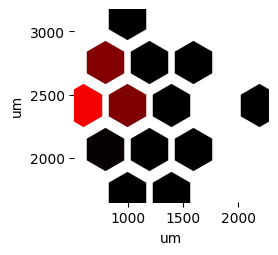

In [9]:
plot_divider = 2E4

ax = plt.figure(figsize=(2.5, 2.5)).gca()

for i, value in enumerate(C.array.sum(axis=0)):
    col = [numpy.minimum(value / plot_divider, 1), 0, 0]
    loc = C.vertices.iloc[i]
    ax.plot(loc["grid-x"], loc["grid-y"], color=col, ms=30, marker="h")

ax.set_frame_on(False)
ax.set_xlabel("um"); ax.set_ylabel("um")
